<a href="https://colab.research.google.com/github/SandaminiI/Android-design/blob/main/Question2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Gymnasium-ready DQN Comparison Notebook**

In [ ]:
pip install swig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.7 MB/s eta 0:00:00


In [ ]:
pip install "gymnasium[box2d]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409533 sha256=1f7666716a396a14f06eb45dfde73b5921cb5031e7584eade6183d8acd6590fb
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

**Q-Network definition**

In [ ]:
class QNetwork(nn.Module):
    """Simple feedforward neural network for Q-value approximation."""
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim) # Output layer: Q-values for each action

    def forward(self, x):
       """Forward pass through network using ReLU activations."""
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)   # No activation on output (Q-values are unbounded)


**Replay Buffer**

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

**DQN Agent with Replay and Target**

In [ ]:
class DQNAgent:
    """Deep Q-Learning agent with experience replay and fixed target network."""
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_size=100000, batch_size=64, target_update=1000, device='cpu'):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update = target_update
        self.device = device

        # Experience replay memory
        self.memory = ReplayBuffer(buffer_size)

        self.policy_net = QNetwork(state_dim, action_dim).to(device)
        # Target network (used for stable Q-value targets)
        self.target_net = QNetwork(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.steps_done = 0

    def select_action(self, state):
        self.steps_done += 1
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def push_memory(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.memory) < self.batch_size:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        q_values = self.policy_net(states).gather(1, actions)
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        if self.steps_done % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

        return loss.item()

**Simple DQN Agent without Replay/Target**

In [ ]:
class SimpleDQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 device='cpu'):

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.device = device

        self.policy_net = QNetwork(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.argmax().item()

    def update(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(self.device)
        action = torch.LongTensor([action]).unsqueeze(0).to(self.device)
        reward = torch.FloatTensor([reward]).unsqueeze(0).to(self.device)
        done = torch.FloatTensor([done]).unsqueeze(0).to(self.device)

        q_value = self.policy_net(state).gather(1, action)
        with torch.no_grad():
            max_next_q_value = self.policy_net(next_state).max(1)[0].unsqueeze(1)
            target_q_value = reward + (1 - done) * self.gamma * max_next_q_value

        loss = self.loss_fn(q_value, target_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

**Environment setup**

In [ ]:
env = gym.make('LunarLander-v3')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
device = 'cpu'  # change to 'cuda' if GPU available

dqn_agent = DQNAgent(state_dim, action_dim, device=device)
simple_agent = SimpleDQNAgent(state_dim, action_dim, device=device)

num_episodes = 500
dqn_rewards, dqn_epsilons, dqn_losses = [], [], []
simple_rewards, simple_epsilons, simple_losses = [], [], []


**Training loop**

In [ ]:
for episode in range(num_episodes):
    # DQN with Replay & Target
    state, info = env.reset(seed=episode)
    total_reward = 0
    done = False
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        dqn_agent.push_memory(state, action, reward, next_state, done)
        loss = dqn_agent.update()
        state = next_state
        total_reward += reward
        if loss is not None:
            dqn_losses.append(loss)
    dqn_rewards.append(total_reward)
    dqn_epsilons.append(dqn_agent.epsilon)

    # Simple DQN
    state, info = env.reset(seed=episode+1000)
    total_reward = 0
    done = False
    while not done:
        action = simple_agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        loss = simple_agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        simple_losses.append(loss)
    simple_rewards.append(total_reward)
    simple_epsilons.append(simple_agent.epsilon)

    if (episode+1) % 10 == 0:
        print(f"Episode {episode+1}: DQN Reward={dqn_rewards[-1]:.2f}, Simple Reward={simple_rewards[-1]:.2f}")

Episode 10: DQN Reward=-241.35, Simple Reward=-194.61
Episode 20: DQN Reward=-76.00, Simple Reward=-114.74
Episode 30: DQN Reward=-191.39, Simple Reward=-164.45
Episode 40: DQN Reward=-149.40, Simple Reward=-157.14
Episode 50: DQN Reward=-159.93, Simple Reward=-111.15
Episode 60: DQN Reward=-148.72, Simple Reward=-113.87
Episode 70: DQN Reward=-124.48, Simple Reward=-159.15
Episode 80: DQN Reward=-46.94, Simple Reward=-141.72
Episode 90: DQN Reward=-231.96, Simple Reward=-107.66
Episode 100: DQN Reward=-121.17, Simple Reward=-143.50
Episode 110: DQN Reward=-36.79, Simple Reward=-3.50
Episode 120: DQN Reward=-26.89, Simple Reward=252.69
Episode 130: DQN Reward=28.29, Simple Reward=229.73
Episode 140: DQN Reward=-28.34, Simple Reward=-86.33
Episode 150: DQN Reward=-31.42, Simple Reward=-102.30
Episode 160: DQN Reward=-156.76, Simple Reward=-109.83
Episode 170: DQN Reward=-75.45, Simple Reward=219.55
Episode 180: DQN Reward=-104.64, Simple Reward=-22.72
Episode 190: DQN Reward=-48.14, Sim

**Plotting comparison**

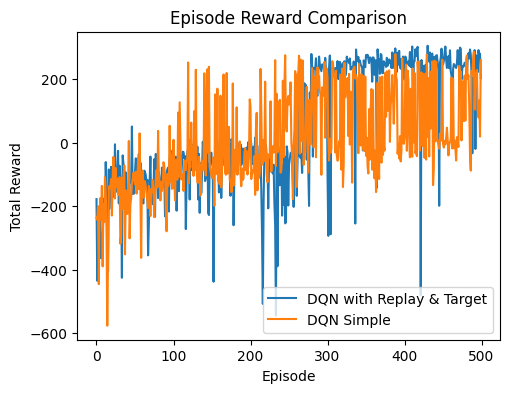

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(dqn_rewards, label="DQN with Replay & Target")
plt.plot(simple_rewards, label="DQN Simple")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode Reward Comparison")
plt.legend()

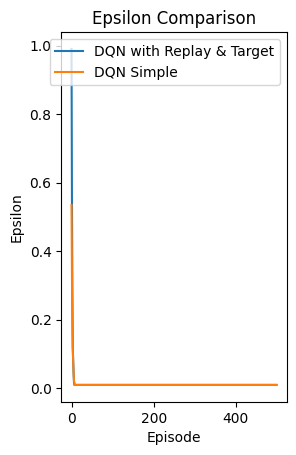

In [ ]:
plt.subplot(1,2,2)
plt.plot(dqn_epsilons, label="DQN with Replay & Target")
plt.plot(simple_epsilons, label="DQN Simple")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Comparison")
plt.legend()
plt.show()

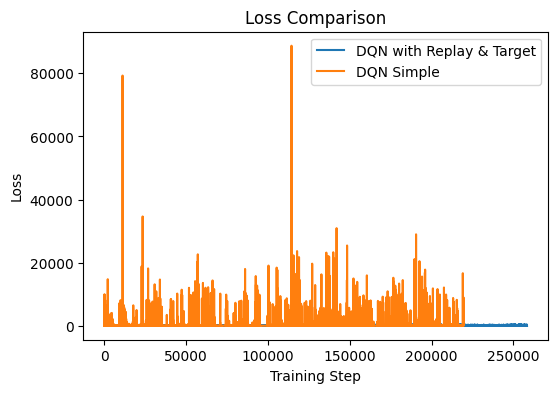

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(dqn_losses, label="DQN with Replay & Target")
plt.plot(simple_losses, label="DQN Simple")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()
plt.show()

***Comparison of the performance of the model with vs. without experience replay and target network stabilization.***

| Feature                        | DQN with Replay & Target                                                                               | DQN Simple (No Replay, No Target)                                                                  |
| ------------------------------ | ------------------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------- |
| **Experience Replay**          |  Stores past transitions and samples random batches. Reduces correlation between consecutive updates. |  Updates online network directly with the most recent transition only. Highly correlated samples. |
| **Target Network**             |  Separate target network updated periodically. Reduces oscillations and divergence in Q-values.       |  Uses same network for target, leading to unstable training.                                      |
| **Stability**                  | High. Training is smoother, less variance in episode rewards.                                          | Low. Episode rewards fluctuate a lot. Training can diverge.                                        |
| **Sample Efficiency**          | High. Each experience can be used multiple times.                                                      | Low. Each experience is used once and then discarded.                                              |
| **Epsilon-Greedy Exploration** | Same as simple DQN. Gradually decays over episodes.                                                    | Same.                                                                                              |
